<a href="https://colab.research.google.com/github/Humboldt-Penguin/Albedo-Hurricane-Research/blob/main/Quantify_Cloud_Cover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Dependencies

In [11]:
from google.colab import drive # access google drive files (auto-made by selecting "mount drive" in files tab on left)
drive.mount('/content/drive')
import os # accessing/modifying files in drive
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

import imageio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# 1. Access Files

In [12]:
# User note: Edit path and extension as appropriate using file finder tab on the left after mounting drive
path = "/content/drive/MyDrive/*Research/Albedo Research/Hurricane Data/01.Hurricane Sandy (2012.292-314, GOES-13, All bands)"

def makeFiles(extension, path = path):
    """
    Create "files" array with all filenames as strings
        Sample parameters:
        extension = "BAND_11.nc"
    """
    files = []
    for filename in os.listdir(path):
        if filename.endswith(extension): 
            # print(filename)
            files.append(filename)
    files = sorted(files)
    return files

---
# 2. Histogram for One Moment in Time

## 2.1. Helper Functions

In [13]:
def create_Intervals(max, spacing, limitless):
    '''
    Automatically generate intervals up to `max` with `spacing` between each value. If `limitless`, add a "[max] and above" interval.
    '''
    intervals = []
    this_interval = 0
    while this_interval <= max:
        this_interval += spacing
        intervals.append(this_interval)
    intervals = sorted(intervals)
    if limitless:
        intervals.append(str(this_interval + 1) + "+")
    return intervals



def create_Histogram(filename, intervals):
    ''' 
    Given a NetCDF file, counts # pixels in each interval
        Note: we're looking at normal array values of float type, we just call them "pixels" because they describe an image
    '''
    # read netCDF file as an array
    file_path = path + "/" + filename
    ds = nc.Dataset(file_path) # ds: "dataset"
    ds.set_auto_mask(False)
    ds = ds["data"][0] # access values with ds[y_index][x_index]

    # loop over all pixels and add to an array if != 0
    pixels = []

    for row in ds: # row of pixels associated with each y index
        for pixel in row: # value of pixel in each row
            if pixel != 0:
                pixels.append(pixel)
    
    # create and return histogram
    fig, ax = plt.subplots(figsize =(10, 7))
    ax.set_ylim([0, 4000])
    # ax.set_title(filename[filename.index(".")+1:filename.index(".sndr")])
    ax.set_title(filename)
    return plt.hist(pixels, bins = intervals)



def create_Histogram_gif(fn, files, interval):
    '''
    creates a gif @fn.gif of histograms created from @files on @interval
    ''' 
    
    filenames = []
    i = 0

    for f in files:
        # interval = create_Intervals(20000, 500, False)
        histogram = create_Histogram(f, interval)

        filename = f'{i}.png'
        i += 1
        filenames.append(filename)

        plt.savefig(filename)
        plt.close()

    with imageio.get_writer(fn + '.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)

    return # if errors, try getting rid of this

## 2.2. Usage

In [15]:
# Inputs
interval = create_Intervals(20000, 500, False)
files = makeFiles("BAND_13.nc")
f = files[16] # Choose a random file

goes13.2012.296.142015.sndr.BAND_13.nc


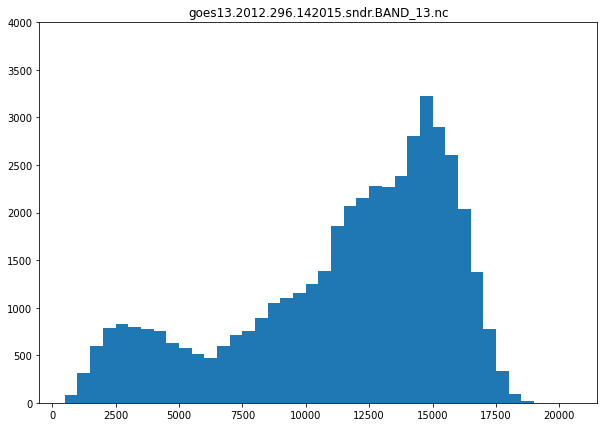

In [16]:
# Single histogram
print(f)
histogram = create_Histogram(f, interval)

In the above histogram, a lower value (x-axis is measured in satellite counts) corresponds to "thicker" clouds. For Band 13, I've chosen 10,000 as the threshold below which pixels count as cloud. This determination was based on visualizing the data in Panoply.

In [ ]:
# gif of histogram from each file
create_Histogram_gif("temp", files, interval)

---
# 3. Thresholding

## 3.1. Helper Functions

In [18]:
def threshold(files, threshold):

    time = []
    cloud_ratio = []
    
    for fn in files:

        # read netCDF file as an array

        file_path = path + "/" + fn
        ds = nc.Dataset(file_path) # ds: "dataset"
        ds.set_auto_mask(False)
        ds = ds["data"][0] # access values with ds[y_index][x_index]

        # calculate ratio of pixels with a value over the threshold to the total number of pixels, add to array

        cloud_pixels = 0
        total_pixels = 0 

        for row in ds: # row of pixels associated with each y index
            for pixel in row: # value of pixel in each row
                if pixel != 0:
                    total_pixels += 1
                    if pixel <= threshold: # MODIFIED TO LEQ
                        cloud_pixels += 1
        
        this_ratio = cloud_pixels / total_pixels

        if this_ratio < 0.99:

            cloud_ratio.append(this_ratio)

            # add time value to array

            datetime_utc = float(fn[fn.index(".", 8)+1 : fn.index(".sndr")])
            day = int(datetime_utc)
            time_utc = datetime_utc % 1
            time_decimal = time_utc / 0.245959
            datetime_decimal = day + time_decimal

            time.append(datetime_decimal)


    return (time, cloud_ratio)



def plot_Threshold(time, cloud_ratio, extension, thresh):
    fig, ax = plt.subplots(figsize = (10, 7))
    ax.set_title("Cloud Cover Over Northern Atlantic During Hurricane Sandy, as Measured by " + extension[:extension.index(".nc")] + "\n(Threshold = " + str(thresh) + ")")
    ax.set_xlabel("Day of Year (out of 365)")
    ax.set_ylabel("% North Atlantic Covered")
    ax.set_xlim([min(time), max(time)])
    ax.set_ylim([0, 1])

    return plt.plot(time, cloud_ratio)

def make_Graph(extension, thresh):
    time, cloud_ratio = threshold(makeFiles(extension), thresh)
    return plot_Threshold(time, cloud_ratio, extension, thresh)

## 2.2. Usage

|Band | Associated cloud threshold|
| --- | ------------------------- |
|03 | 27,000|
|04 | 27,000|
|05 | 29,000|
|06 | 33,000|
|07 | 31,000|
|08 | 27,000|
|09 | 18,000|
|10 | 19,000|
|11 | 18,000|
|12 | 11,000|
|13 | 10,000|
|14 | 8,000|
|15 | 6,000|
|16 | 7,000|
|17 | 8,000|
|18 | 8,000|
|19 | 10,000|

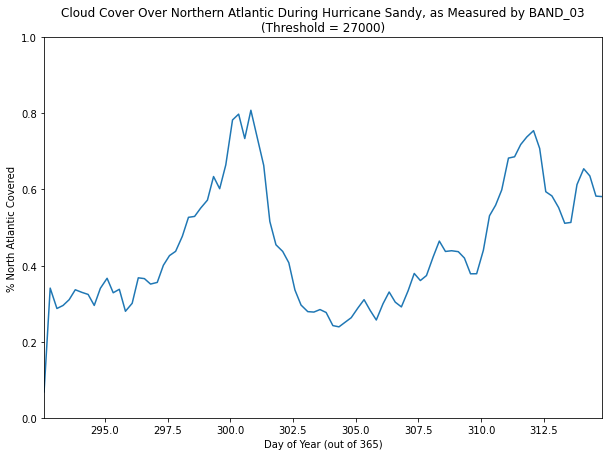

In [19]:
graph = make_Graph("BAND_03.nc", 27000)

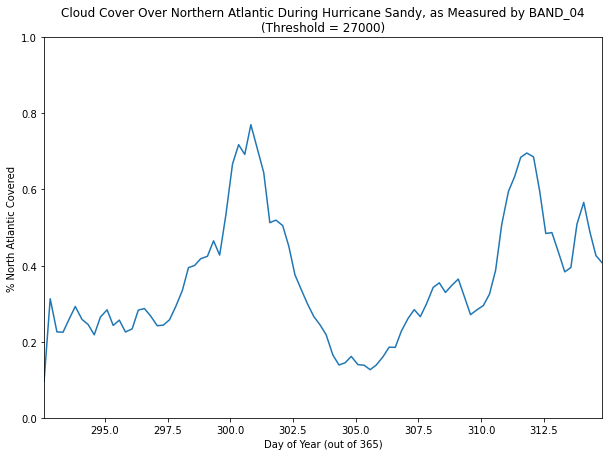

In [20]:
graph = make_Graph("BAND_04.nc", 27000)

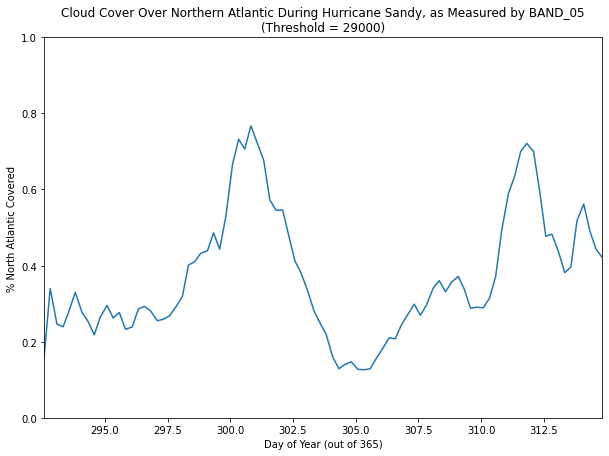

In [21]:
graph = make_Graph("BAND_05.nc", 29000)

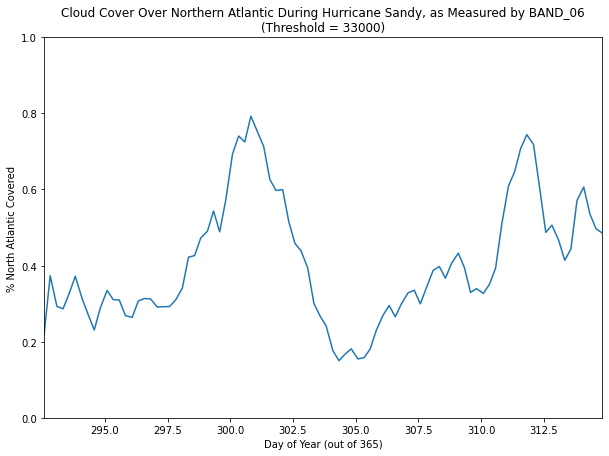

In [22]:
graph = make_Graph("BAND_06.nc", 33000)

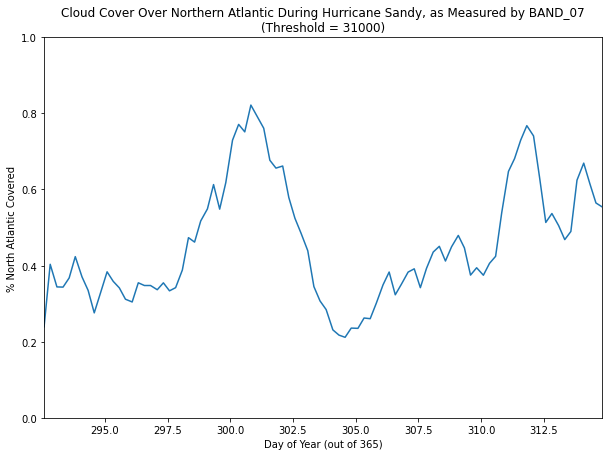

In [23]:
graph = make_Graph("BAND_07.nc", 31000)

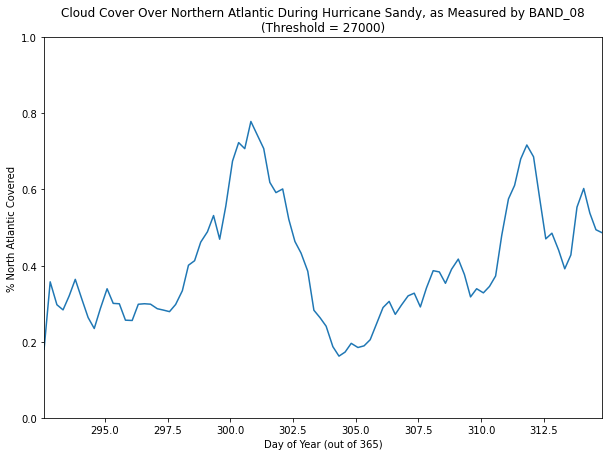

In [24]:
graph = make_Graph("BAND_08.nc", 27000)

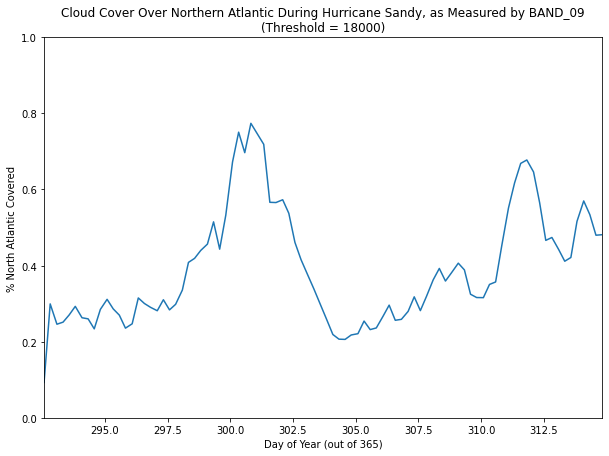

In [25]:
graph = make_Graph("BAND_09.nc", 18000)

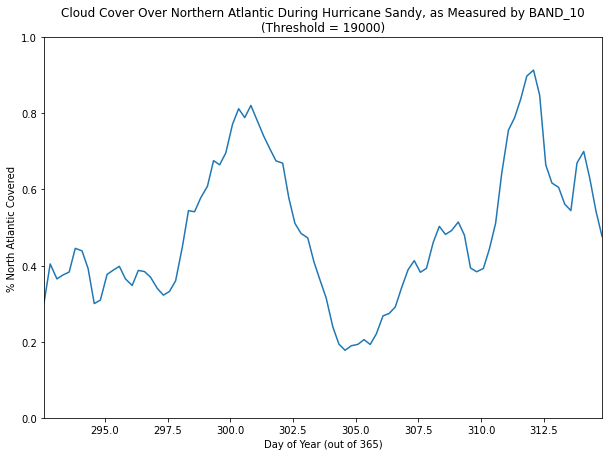

In [26]:
graph = make_Graph("BAND_10.nc", 19000)

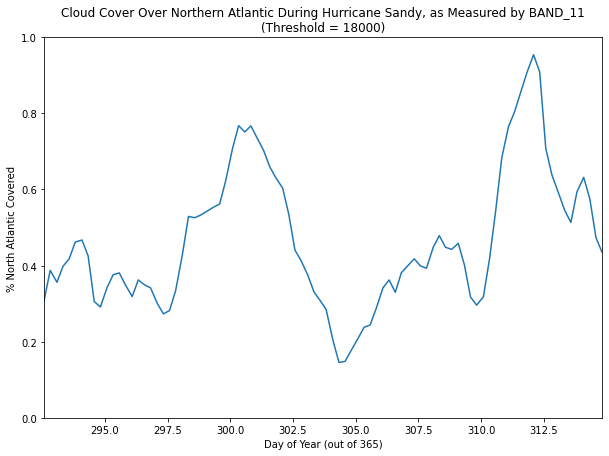

In [27]:
graph = make_Graph("BAND_11.nc", 18000)

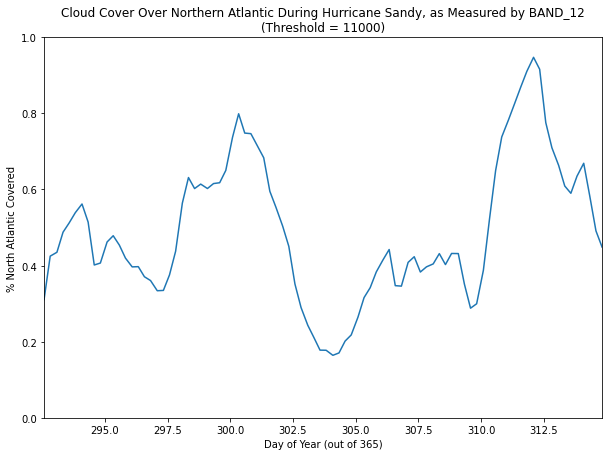

In [28]:
graph = make_Graph("BAND_12.nc", 11000)

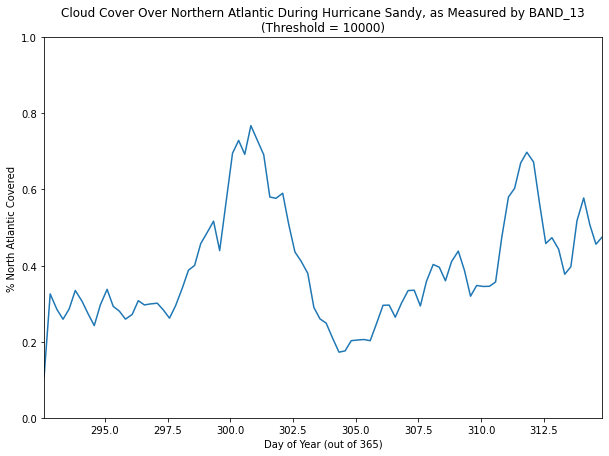

In [29]:
graph = make_Graph("BAND_13.nc", 10000)

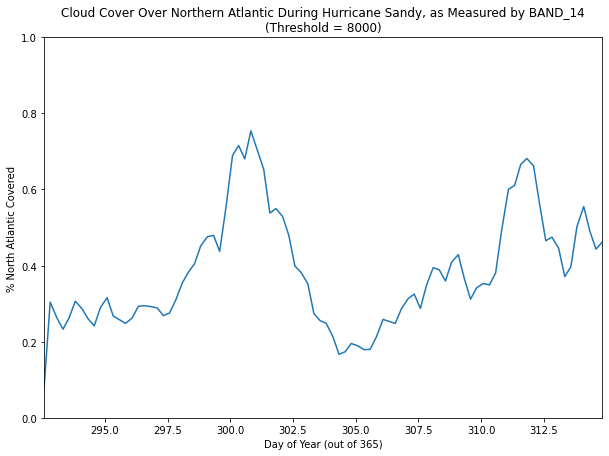

In [30]:
graph = make_Graph("BAND_14.nc", 8000)

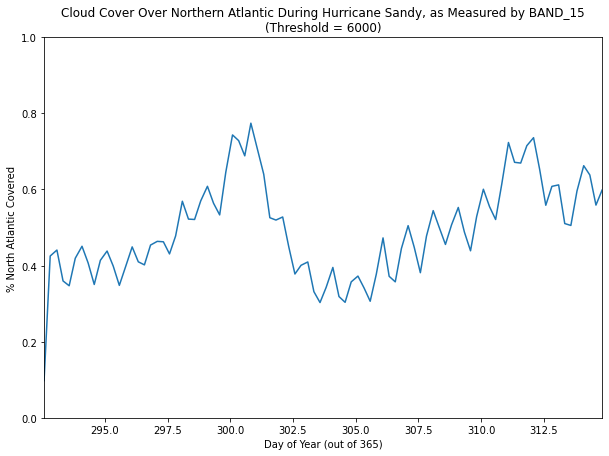

In [31]:
graph = make_Graph("BAND_15.nc", 6000)

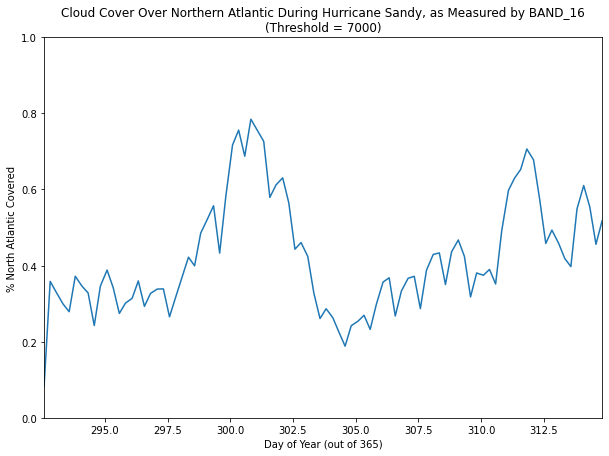

In [32]:
graph = make_Graph("BAND_16.nc", 7000)

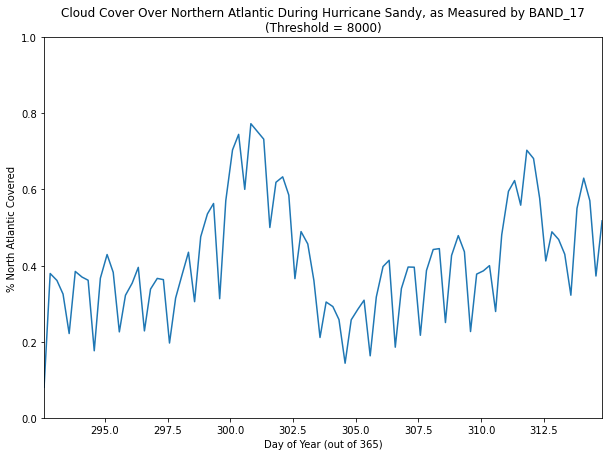

In [33]:
graph = make_Graph("BAND_17.nc", 8000)

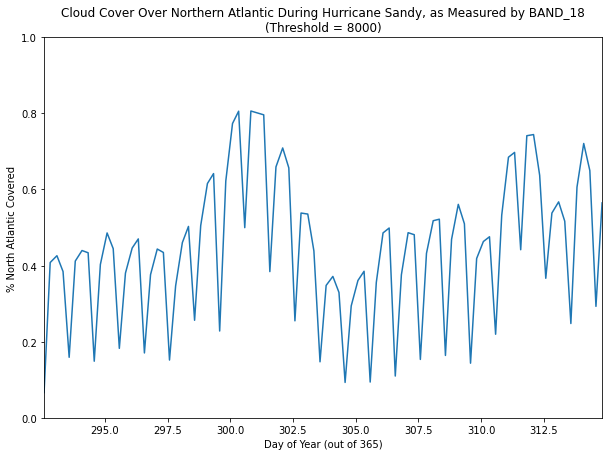

In [34]:
graph = make_Graph("BAND_18.nc", 8000)

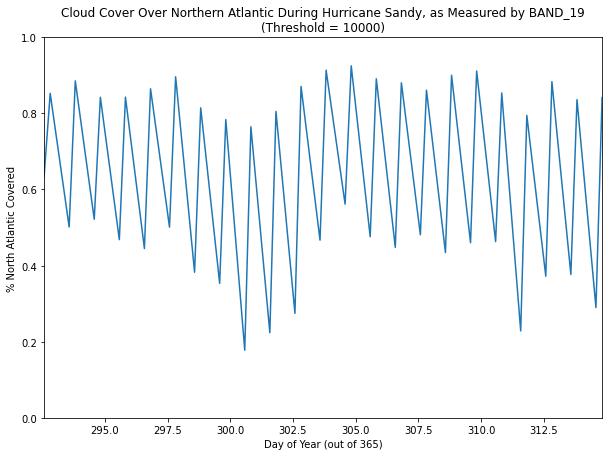

In [35]:
graph = make_Graph("BAND_19.nc", 10000)

---
# 3. Combine into One nc File (Incomplete)

In [ ]:
path = "/content/drive/MyDrive/*Research/Albedo Research/Hurricane Data/01.Hurricane Sandy (2012.292-314, GOES-13, All bands)"
extension = "BAND_09.nc"

files = []
for filename in os.listdir(path):
    if filename.endswith(extension): 
        # print(filename)
        files.append(path + "/" + filename)
files = sorted(files)


import xarray as xr


dt = xr.open_mfdataset(files, combine="by_coords", concat_dim="time")

In [ ]:
dt.to_netcdf("combine_band2")

---
---
---
# Scrap Code

In [ ]:
def fill_Intervals(filename, intervals):
    ''' 
    Given a NetCDF file, counts # pixels in each interval
        Note: we're looking at normal array values, we just call them "pixels" because they describe an image
    '''

    # associate a pixel count which each interval, representing the # pixels less than or equal to the interval value
    temp = []
    for interval in intervals:
        temp.append([interval, 0])
    intervals = temp

    # read netCDF file as an array
    file_path = path + "/" + filename
    ds = nc.Dataset(file_path) # ds: "dataset"
    ds.set_auto_mask(False)
    ds = ds["data"][0] # access values with ds[y_index][x_index]

    # loop over array and sort into intervals (while counting total pixels)
    total_pixels = 0 

    for row in ds: # row of pixels associated with each y index
        for pixel in row: # value of pixel in each row
            if pixel != 0:
                total_pixels += 1
                for interval in intervals:
                    if type(interval[0]) == int:
                        if pixel <= interval[0]:
                            interval[1] += 1
                            break
                    else:
                        interval[1] += 1
    return intervals

fill_Intervals(files[0], intervals)

[[200, 13],
 [400, 11],
 [600, 24],
 [800, 31],
 [1000, 68],
 [1200, 93],
 [1400, 140],
 [1600, 180],
 [1800, 203],
 [2000, 232]]

#### Option 2: Manually Entered

In [ ]:
intervals = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
limitless = False

intervals = sorted(intervals)
if limitless:
    intervals.append(str(intervals[len(intervals)-1]) + "+")
# print("Intervals:")
# print(intervals)

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]


In [ ]:
for fn in files:
    interval = create_Intervals(20000, 500, False)
    histogram = create_Histogram(fn, interval)

In [ ]:
# loop over all files and threshold

for file in files:
    # convert nc dataset into numpy array
    ds = nc.Dataset(file)

FileNotFoundError: ignored

In [ ]:
#@title Inputs { run: "auto" }

file_index = 0 #@param {type:"slider", min:0, max:46, step:1}
interval_max = 20000 #@param {type:"integer"}
interval_spacing = 500 #@param {type:"slider", min:500, max:2500, step:500}

interval = create_Intervals(interval_max, interval_spacing, False)

